<a href="https://colab.research.google.com/github/aljebraschool/Convolutional_neural_network/blob/main/cifar10_cnn_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/notebook_ims/cifar_data.png?raw=1' width=50% height=50% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


---
## Load the [Data](https://pytorch.org/vision/stable/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [5]:
# Data transform to convert data to a tensor and apply normalization

# augment train and validation dataset with RandomHorizontalFlip and RandomRotation
train_transform = transforms.Compose([
    # TODO transform data with RandomHorizontalFlip()
    transforms.RandomHorizontalFlip(),
    # TODO transform data with RandomRotation()
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [6]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 50009838.82it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [7]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [8]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

### Visualize a Batch of Training Data

In [10]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display


In [12]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

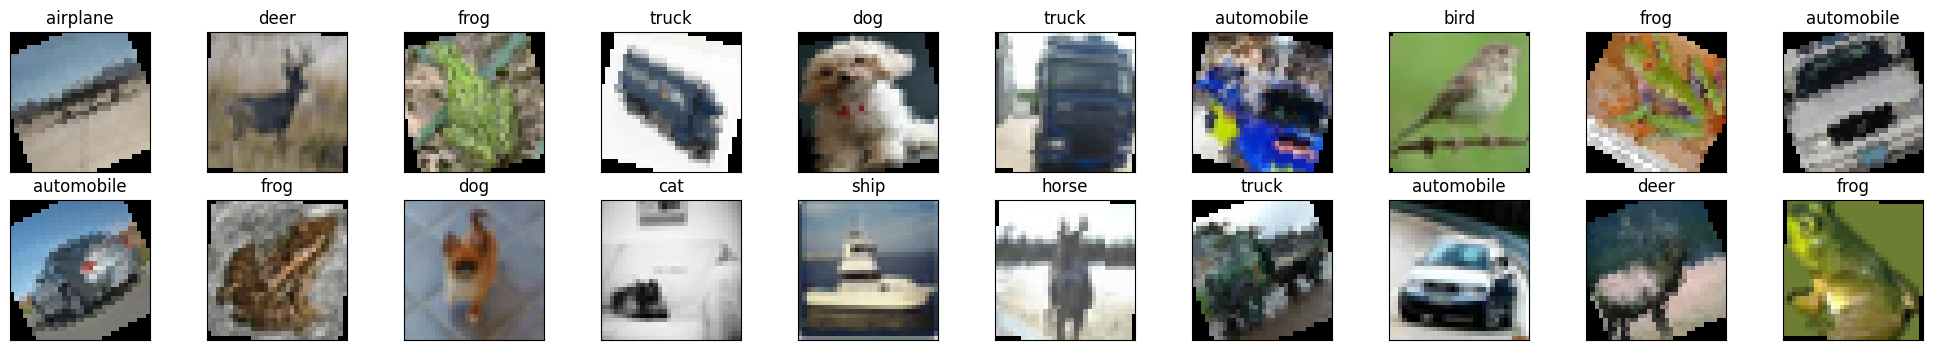

In [13]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

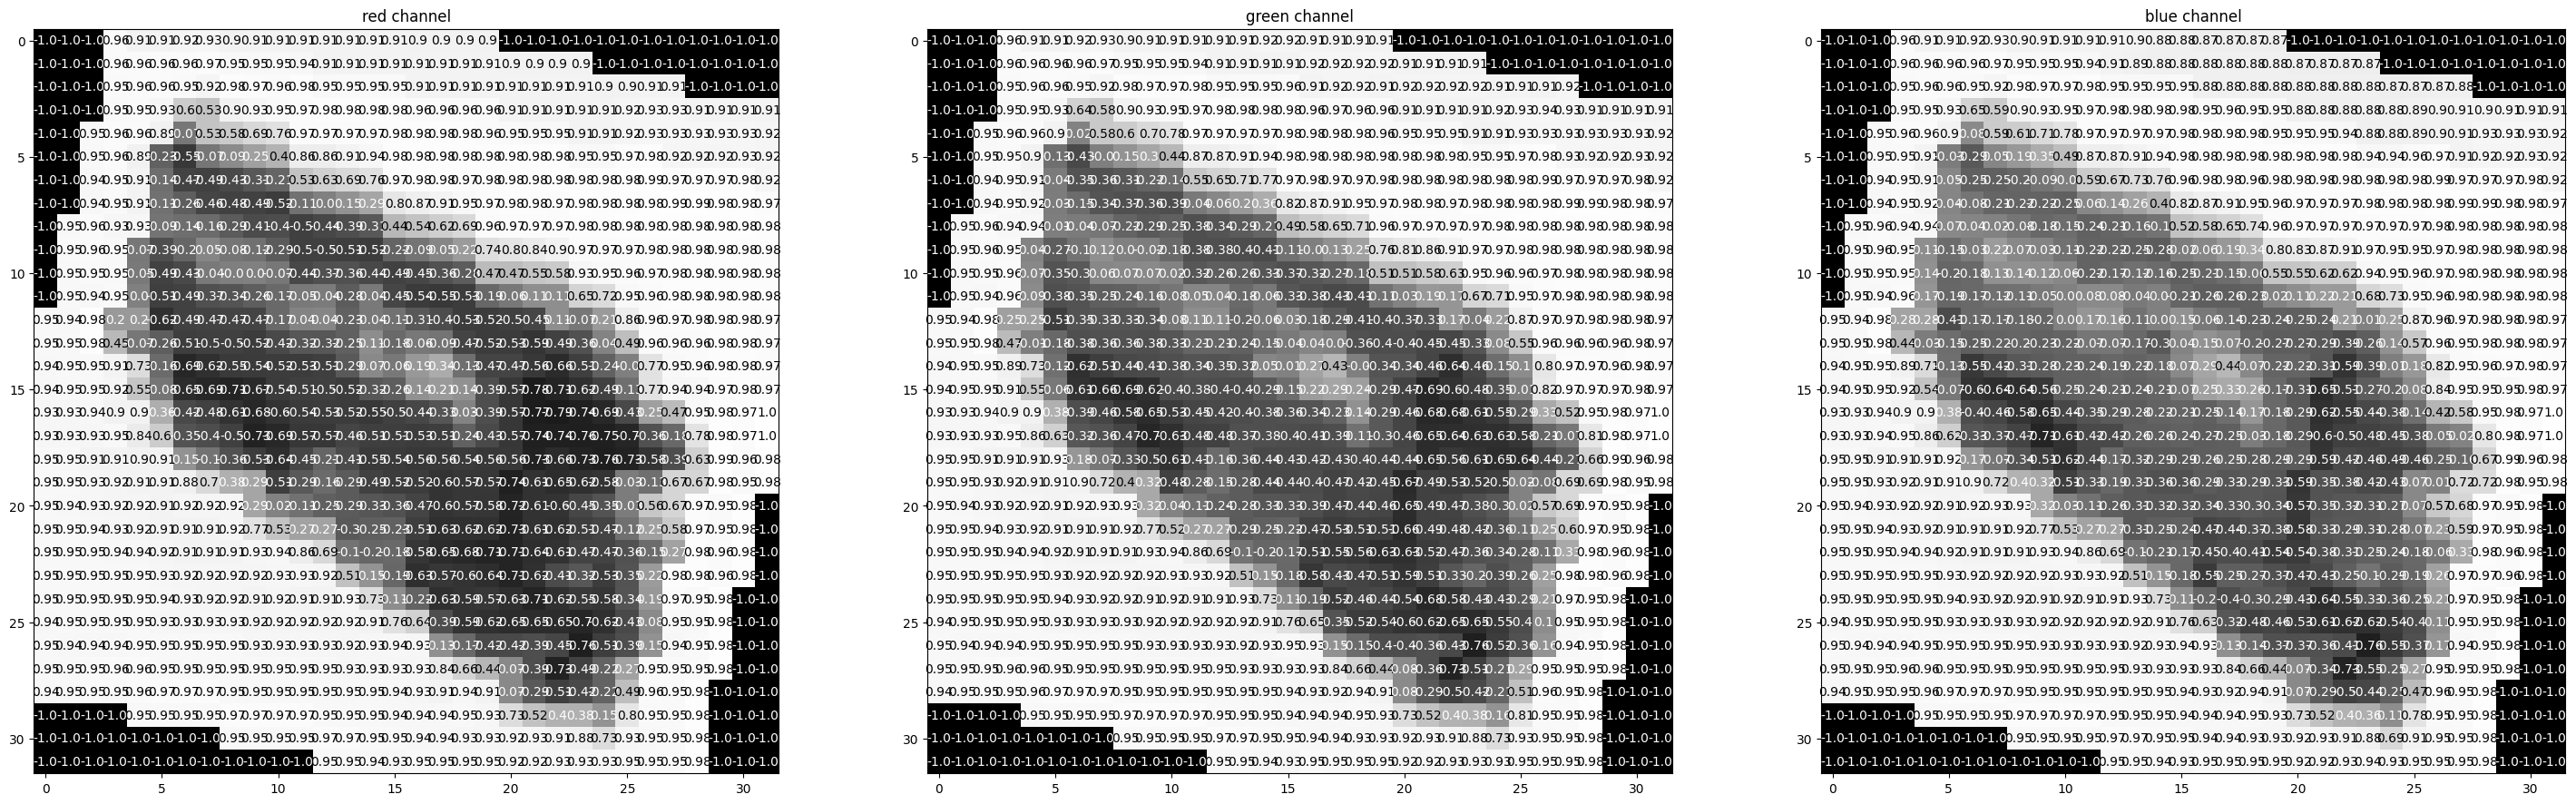

In [14]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [15]:
print(images.shape)
print(type(images))

(20, 3, 32, 32)
<class 'numpy.ndarray'>


---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#convolution-layers), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/notebook_ims/2_layer_conv.png?raw=1' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this Keras example](https://keras.io/examples/vision/mnist_convnet/) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [16]:
#A numpy Images with (20, 3, 32, 32)
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #first convolutional neural network
        self.convo1 = nn.Conv2d(3, 16, 3, padding = 1)


        #second convolutional neural network
        self.convo2 = nn.Conv2d(16, 32, 3, padding = 1)

        #third convolutional neural network
        self.convo3 = nn.Conv2d(32, 64, 3, padding = 1)


        #activate max pooling to reduce the feature maps layers
        self.pooling = nn.MaxPool2d((2, 2))

        #fully connected layer 1
        self.fc1 = nn.Linear(64 * 4 * 4, 300)

        #output layer
        self.output = nn.Linear(300, 10)

        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.20)



    #define the forward pass function
    def forward(self, x):

        #pass the first layer to relu and apply max pooling to reduce its size
        x = self.pooling(F.relu(self.convo1(x)))

        #pass the second layer to relu and apply max pooling to reduce its size
        x = self.pooling(F.relu(self.convo2(x)))

        #pass the third layer to relu and apply max pooling to reduce its size
        x = self.pooling(F.relu(self.convo3(x)))

        #flatten the input starting from the first index (height then weight)
        x = torch.flatten(x, 1)

        #apply dropout before passing to the linear layer
        x = self.dropout(x)

        #pass the input to linear layer then to relu function
        x = F.relu(self.fc1(x))

        #apply dropout again
        x = self.dropout(x)

        #pass to the outer layer
        x = self.output(x)

        return x


model = Net()

In [17]:
model = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://onlytojay.medium.com/mnist-cnn-optimizer-comparison-with-tensorflow-keras-163735862ecd). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [18]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.02)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [ ]:
# number of epochs to train the model
n_epochs = 35

valid_loss_min = np.Inf # track change in validation loss

train_losses, validation_losses = [], []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)


    train_losses.append(train_loss)
    validation_losses.append(valid_loss)


    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.098789 	Validation Loss: 1.678841
Validation loss decreased (inf --> 1.678841).  Saving model ...
Epoch: 2 	Training Loss: 0.078490 	Validation Loss: 1.436117
Validation loss decreased (1.678841 --> 1.436117).  Saving model ...
Epoch: 3 	Training Loss: 0.071375 	Validation Loss: 1.402098
Validation loss decreased (1.436117 --> 1.402098).  Saving model ...
Epoch: 4 	Training Loss: 0.066924 	Validation Loss: 1.248131
Validation loss decreased (1.402098 --> 1.248131).  Saving model ...
Epoch: 5 	Training Loss: 0.063014 	Validation Loss: 1.242188
Validation loss decreased (1.248131 --> 1.242188).  Saving model ...
Epoch: 6 	Training Loss: 0.060384 	Validation Loss: 1.122839
Validation loss decreased (1.242188 --> 1.122839).  Saving model ...
Epoch: 7 	Training Loss: 0.058068 	Validation Loss: 1.107947
Validation loss decreased (1.122839 --> 1.107947).  Saving model ...
Epoch: 8 	Training Loss: 0.055859 	Validation Loss: 1.053223
Validation loss decreased (1.10794

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

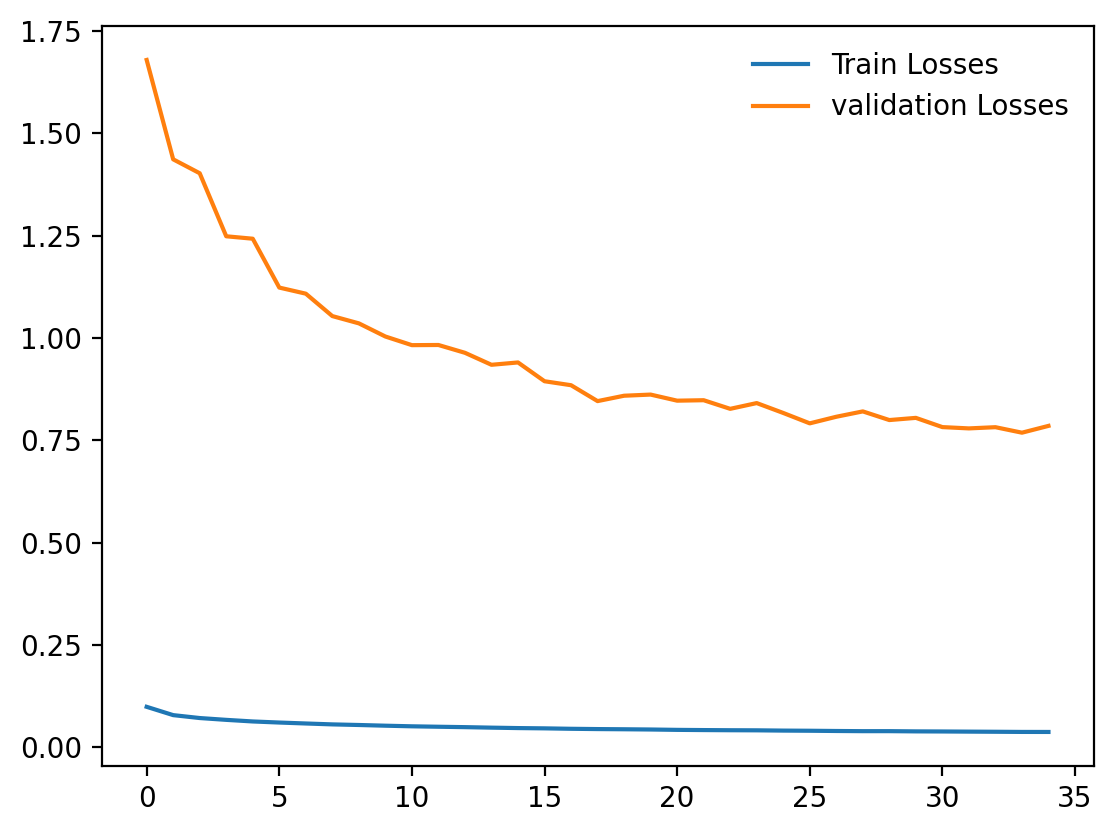

In [ ]:
plt.plot(train_losses, label = "Train Losses")
plt.plot(validation_losses, label = "validation Losses")
plt.legend(frameon=False)

In [ ]:
#load the saved model
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [ ]:
# use the test data to test the accuracy of the model prediction

#define your variable to keep track of loss and predictions
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.690763

Test Accuracy of airplane: 83% (836/1000)
Test Accuracy of automobile: 89% (892/1000)
Test Accuracy of  bird: 64% (648/1000)
Test Accuracy of   cat: 55% (556/1000)
Test Accuracy of  deer: 77% (773/1000)
Test Accuracy of   dog: 66% (664/1000)
Test Accuracy of  frog: 80% (807/1000)
Test Accuracy of horse: 81% (811/1000)
Test Accuracy of  ship: 82% (821/1000)
Test Accuracy of truck: 78% (788/1000)

Test Accuracy (Overall): 75% (7596/10000)


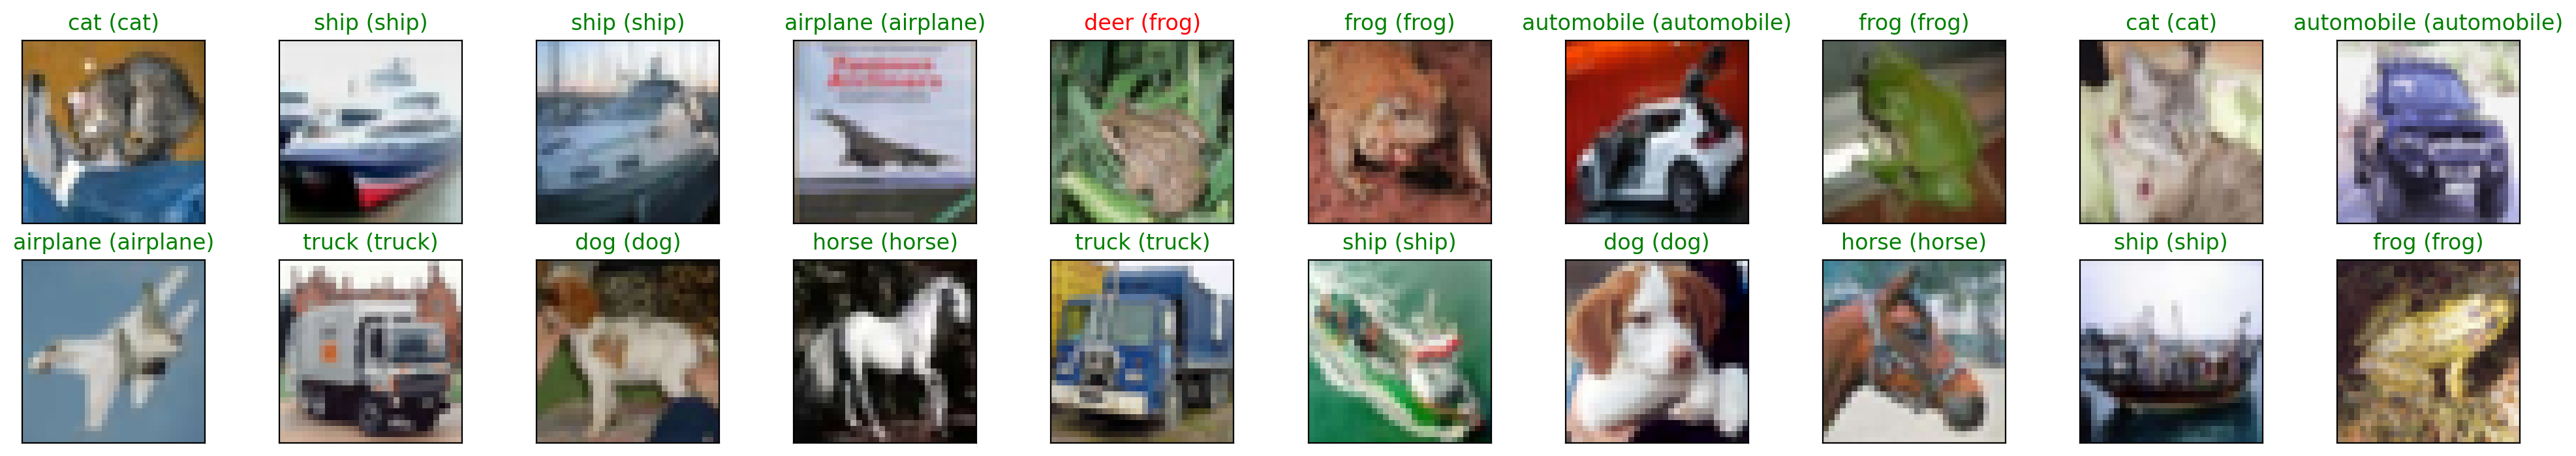

In [ ]:
# final visualization of the model perfomance
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [ ]:
#defining another model with different hyperparameters

#A numpy Images with (20, 3, 32, 32)


# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #first convolutional neural network
        self.convo1 = nn.Conv2d(3, 32, 3, padding = 1)


        #second convolutional neural network
        self.convo2 = nn.Conv2d(32, 64, 3, padding = 1)

        #third convolutional neural network
        self.convo3 = nn.Conv2d(64, 128, 3, padding = 1)



        #activate max pooling to reduce the feature maps layers
        self.pooling = nn.AdaptiveMaxPool2d((2, 2))

        #fully connected layer 1
        self.fc1 = nn.Linear(128* 2 * 2, 500)

        #output layer
        self.output = nn.Linear(500, 10)

        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)



    #define the forward pass function
    def forward(self, x):

        x = self.pooling(F.relu(self.convo1(x)))

        x = self.pooling(F.relu(self.convo2(x)))

        x = self.pooling(F.relu(self.convo3(x)))


        x = torch.flatten(x, 1)


        x = self.dropout(x)

        x = F.relu(self.fc1(x))

        x = self.dropout(x)


        x = self.output(x)

        return x


model = Net()

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [19]:
#retraining the model using own code

# number of epochs to train the model
epochs = 45 # suggest training between 20-50 epochs

#best validation loss so far
best_validation_loss = float('inf')

#early stopping when loss is not changing
early_patience_stopping = 10

#keep track of the validation loss is < previous validation loss
patience_counter = 0


model.train() # prep model for training

train_losses, validation_losses = [], []
for e in range(epochs):
    # monitor training loss
    train_loss = 0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()

    else:
      validation_loss = 0
      model.eval()
      with torch.no_grad():
        for images, labels in valid_loader:
          log_ps = model(images)
          loss = criterion(log_ps, labels)
          validation_loss += loss.item()


      model.train()
      #average of all loss accross the whole validation dataset
      validation_loss = validation_loss/len(valid_loader)

      ## implementing early stopping algorithm ##

      #compare the present accumulated loss in the epoch with the best loss set before entering this loop
      if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')

      #if false, increase the patience counter then compare it with early stopping and break out of the loop
      else:
        patience_counter += 1
        if patience_counter >= early_patience_stopping:
          print(f'Early stopping at {e}')
          break

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)

    #put the average of every epoch loss in a list
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)


    print(f'Epoch: {e+1}/{epochs}...'
          f'Train Loss: {train_loss:>5.3f}...'
          f'Validation Loss: {validation_loss:>5.3f}...'
          )




In [20]:
plt.plot(train_losses, label = "Train Losses")
plt.plot(validation_losses, label = "validation Losses")
plt.legend(frameon=False)
plt.show()

In [ ]:
# #this code loads it in our model with the same architecture for use
model.load_state_dict(torch.load('best_model.pth'))
# load model state dictionary
model.state_dict().keys()

odict_keys(['convo1.weight', 'convo1.bias', 'convo2.weight', 'convo2.bias', 'fc1.weight', 'fc1.bias', 'output.weight', 'output.bias'])

In [21]:
#now using my own code to test the accuracy of the model

epochs = 10
for e in range(epochs):
  accuracy = 0
  test_set_loss = 0
  with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        test_set_loss += loss.item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

  # Calculate average test loss and accuracy
  test_loss = test_set_loss / len(test_loader)
  accuracy /= len(test_loader)

  print("Test Loss: {:>5.3f}.. ".format(test_loss),
        "Accuracy: {:>5.3f}%.. ".format(accuracy.item() * 100))





###  Load the Model with the Lowest Validation Loss

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [22]:
# Final visualization of the model using my own code
dataiter = iter(test_loader)

# Obtain one batch of test images
images, labels = next(dataiter)

img = images[0].view(1, -1)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)


ps = ps.data.numpy().squeeze()

fig = plt.figure(figsize = (20, 5))

for index in range(20):
  ax = fig.add_subplot(2, 10, index + 1, xticks = [], yticks = [])
  ax.imshow(img.data.numpy().squeeze(), cmap = 'gray')
  ax.set_title("{} ({})".format(str(classes[ps[index]].item(), str(classes[labels[index]].item()))),
               color = 'green' if ps[index] == labels[index] else 'red')





### Question: What are your model's weaknesses and how might they be improved?

**Answer**: # TODO add your answer here

### Visualize Sample Test Results